# KPMG Skill Assesment - Juan Livinalli
## Named Entity Recognition on the MIT Movie Corpus
In this notebook I will develop the code to train a model to be able to perform NER on the MIT Movie Corpus and on new sentences. For this NLP task I will use the neural network library Keras to design and train a neural network to perform NER.

In [82]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed, Bidirectional
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

## Loading the Data
First, I download the engtest test and engtrain dataset from the MIT Movie Corpus and save them in the 'data' folder.

In [83]:
!curl https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio -o data/test.txt
!curl https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio -o data/train.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
 77  246k   77  192k    0     0  61982      0  0:00:04  0:00:03  0:00:01 61962
100  246k  100  246k    0     0  79595      0  0:00:03  0:00:03 --:--:-- 79570
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  989k    0     0    0     0      0      0 --:-

Next, I will define a function to transform the BIO format into a list of sentences and a list of tags. I will the use this function to create the X predictor variables and the Y tags to be predicted.

In [84]:
def load_data(file):
    file = open(file, 'r')
    data_x, data_y = [], []
    sentence, labels = [], []
    for i in file:
        line = i.strip("\n").split("\t")
       
        #len > 1 are words
        if len(line) > 1:
            sentence.append(line[1])
            labels.append(line[0][2:]) if len(line[0]) > 1 else labels.append(line[0])
       
        #len == 1 are sentence breaks
        if len(line) == 1:
            data_x.append(' '.join(sentence))
            data_y.append(labels)
            sentence, labels = [], []
    return data_x, data_y

train_x, train_y = load_data("data/train.txt")
test_x, test_y = load_data("data/test.txt")

## Exploratory Data Analysis
Now, lets a look at the data in x and y:

In [85]:
train_x[:10]

['what movies star bruce willis',
 'show me films with drew barrymore from the 1980s',
 'what movies starred both al pacino and robert deniro',
 'find me all of the movies that starred harold ramis and bill murray',
 'find me a movie with a quote about baseball in it',
 'what movies have mississippi in the title',
 'show me science fiction films directed by steven spielberg',
 'do you have any thrillers directed by sofia coppola',
 'what leonard cohen songs have been used in a movie',
 'show me films elvis films set in hawaii']

In [86]:
train_y[:10]

[['O', 'O', 'O', 'ACTOR', 'ACTOR'],
 ['O', 'O', 'O', 'O', 'ACTOR', 'ACTOR', 'O', 'O', 'YEAR'],
 ['O', 'O', 'O', 'O', 'ACTOR', 'ACTOR', 'O', 'ACTOR', 'ACTOR'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'ACTOR',
  'ACTOR',
  'O',
  'ACTOR',
  'ACTOR'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'TITLE', 'O', 'O', 'O'],
 ['O', 'O', 'GENRE', 'GENRE', 'GENRE', 'O', 'O', 'DIRECTOR', 'DIRECTOR'],
 ['O', 'O', 'O', 'O', 'GENRE', 'O', 'O', 'DIRECTOR', 'DIRECTOR'],
 ['O', 'SONG', 'SONG', 'SONG', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'ACTOR', 'O', 'PLOT', 'PLOT', 'PLOT']]

Lets see how many sentences we have in the train and test data. I also want to see what's the longest sentence.

In [87]:
def sentence_feat(data_x):
    #total amount of sentences in the dataset
    total_sent = len(data_x)
    print('total amount of sentences:',total_sent)

    #longest sentence length in the dataset
    maxlen = max([len(s) for s in data_x])
    print ('Maximum sentence length:', maxlen)

print('train data')
sentence_feat(train_x)
print('test data')
sentence_feat(test_x)

train data
total amount of sentences: 9775
Maximum sentence length: 258
test data
total amount of sentences: 2443
Maximum sentence length: 175


The maximum sentence is quite long, I will plot a histogram of the sentences lenght to see what is the sentence size for the majority of the data.

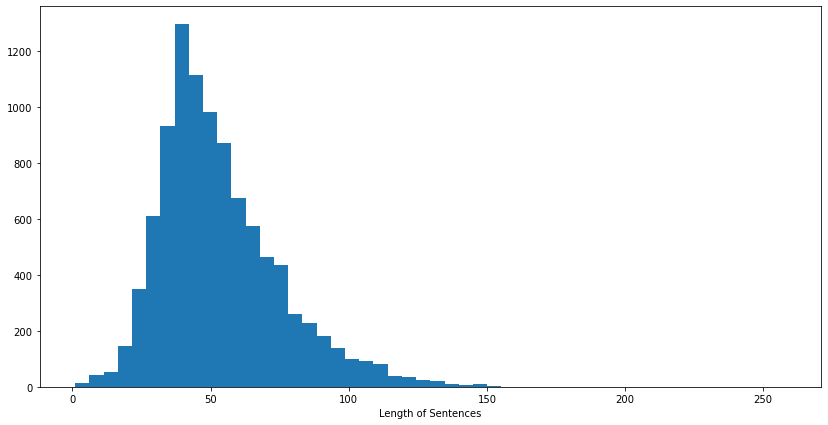

In [88]:
def sentence_hist(data_x):
    plt.figure(figsize=(14,7))
    plt.hist([len(s) for s in data_x],bins = 50)
    plt.xlabel("Length of Sentences")
    plt.show()
    
sentence_hist(train_x)

The plot shows that the average lenght of a sentence in the data is near 50 words. 
## Data Preprocessing
In order to prepare the data so that it can be used by the model, I will perform the following tranformation:

Tokenize the data: The model doesn't not understand words, therefore the input data needs to be transformed through a process called tokenization where a number will be assigned to each distinct word. Here I've place the limit to tokenize up to 10000 words and I've also allocated one number for all words not in the vocabulary OOV.

Pad the data: for our recurrent neural network to work we need all inputs to have the same dimensions, therefore we will make all sentence size equal by padding small sentences and truncating big sentences. I've chosen 50 as the number of words for all input sentences since, as seen in the histogram, the majority of sentences in the data have around 50 words.

Perform word embeddings: I will use Keras embedding layer to embed the one-hot encoded words in the input into embedded words. By performing word embeddings I can reduce the dimensionality of my input from 10000 vectors to 100 vectors in an embedded matrix which is very helpful at reducing the complexity of our model since it will not need as many parametes if the input uses 100 vectors per word. Also, by training this layer, the embedding will find relationships between words in the vocab which can be very helpful for training the model.

In [89]:
MAX_WORDS = 10000  #total words being tokenized
MAX_LEN = 50       #total length of sentence

#fit tokenizer
tokenizer = Tokenizer (num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index

#tokenize & pad train data
train_x_idx = tokenizer.texts_to_sequences(train_x)
train_x_idx = pad_sequences(train_x_idx, maxlen=MAX_LEN, padding='post')

#tokenize & pad test data
test_x_idx = tokenizer.texts_to_sequences(test_x)
test_x_idx = pad_sequences(test_x_idx, maxlen=MAX_LEN, padding='post')

Having a look at the word index created by the tokenization of the data:

In [90]:
word_index

{'<OOV>': 1,
 'the': 2,
 'a': 3,
 'movie': 4,
 'what': 5,
 'in': 6,
 'is': 7,
 'movies': 8,
 'that': 9,
 'was': 10,
 'rated': 11,
 'of': 12,
 'with': 13,
 'film': 14,
 'about': 15,
 'directed': 16,
 'there': 17,
 'me': 18,
 'by': 19,
 'from': 20,
 'find': 21,
 'list': 22,
 'pg': 23,
 'and': 24,
 'did': 25,
 'are': 26,
 'starring': 27,
 's': 28,
 'any': 29,
 'an': 30,
 'r': 31,
 'for': 32,
 'who': 33,
 'show': 34,
 'last': 35,
 'has': 36,
 '13': 37,
 'good': 38,
 'films': 39,
 'name': 40,
 'rating': 41,
 'stars': 42,
 'i': 43,
 'past': 44,
 'you': 45,
 'to': 46,
 'out': 47,
 'year': 48,
 'years': 49,
 'released': 50,
 'which': 51,
 'have': 52,
 'decades': 53,
 'comedy': 54,
 'star': 55,
 'made': 56,
 'some': 57,
 'all': 58,
 'action': 59,
 'direct': 60,
 'on': 61,
 'looking': 62,
 'starred': 63,
 'horror': 64,
 'g': 65,
 'were': 66,
 'do': 67,
 'average': 68,
 'where': 69,
 'received': 70,
 'many': 71,
 'fantasy': 72,
 'ever': 73,
 'drama': 74,
 'seven': 75,
 'it': 76,
 'how': 77,
 'rat

Having a look at one of the tokenized and padded sentences:

In [91]:
train_x_idx[0]

array([  5,   8,  55, 257, 354,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

Now, I transform the tags in Y to vectors as well. In this case I want to have 13 vectors per tag, each one representing one category. 

In [92]:
def tag_dict(data):
    data_flattened = [item for sublist in data for item in sublist]  
    tags = list(set(data_flattened))    #list of tags
    tag_idx={}
    for x,tag in enumerate(tags):
        tag_idx[tag]=x                  #dict of tags
    return tag_idx, len(tag_idx), tags

y_dict, dictTot, tags = tag_dict(train_y)

y_dict

{'DIRECTOR': 0,
 'RATINGS_AVERAGE': 1,
 'RATING': 2,
 'SONG': 3,
 'TITLE': 4,
 'PLOT': 5,
 'CHARACTER': 6,
 'YEAR': 7,
 'GENRE': 8,
 'REVIEW': 9,
 'ACTOR': 10,
 'TRAILER': 11,
 'O': 12}

In [93]:
def tag_transform(tag_dict, data_y, max_len):
    y = [[tag_dict[w] for w in s] for s in data_y]
    y =pad_sequences(y, maxlen=max_len, padding='post', value = y_dict['O'])
    y = [to_categorical(i, num_classes = dictTot) for i in  y]
    return y

train_y_idx = tag_transform(y_dict,train_y,MAX_LEN)
test_y_idx = tag_transform(y_dict,test_y,MAX_LEN)

train_y_idx[0][:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 

## Model Selection and evaluation

Now that the data is transformed into the correct format, I proceed to build the model. 

I will use a Bidirectional LSTM (Long Short Term Memory) model as these models tend to perform well on natural language tasks. When assessing a word, Bidirectional LSTM models are capabe of taking account previous words and later words in the sentence in order to provide context, this is one of the main advantages of this model as the nature of a word is often defined by it's context within a sentence.

For this model I will also use a dropout layer and a recurrent dropout in order to regularize the model to ensure it generalizes well to unseen data.

Finally, I've placed a dense layer right after the LSTM layer with 13 outputs (1 for each category) from which later I can pick the vector output with the highest probability as the predicted tag for the specific word.

In [139]:
DIM = 100  #dimension of word embedding

#####Model#####
input_words = Input(shape = (MAX_LEN,))
model = Embedding(input_dim = MAX_WORDS, output_dim = DIM, input_length = MAX_LEN)(input_words)
model = Dropout(0.2)(model)
model = Bidirectional(LSTM(units = 128,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(dictTot, activation = 'softmax'))(model)
model = Model(inputs=input_words, outputs=out)

I will compile the model using an adam optimizer and use the categorical crossentropy loss function (as I'm trying to predict the different categories of tags). Finally, I will use accuracy as the performance metric to evaluate the model.

In [140]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 50, 256)           234496    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 50, 13)            3341      
Total params: 1,237,837
Trainable params: 1,237,837
Non-trainable params: 0
_________________________________________________________________


Above,I can see the layers and total parameters of my model as well as the tensor shapes of each layer. I want to make sure that my X and Y have the same dimensions as the model input and output.

In [141]:
train_y_idx=np.array(train_y_idx)
test_y_idx=np.array(test_y_idx)

print(train_x_idx.shape)
print(train_y_idx.shape)

(9775, 50)
(9775, 50, 13)


I can see that the dimensions match with the model requirements, so I proceed to fit the model. I use an input batch size of 64, I will leave 20% of the data for validation, and will run 10 epochs on the model.

In [142]:
model.fit(train_x_idx, train_y_idx, batch_size = 64, verbose = 1, epochs = 10, validation_split = 0.2)

Epoch 1/10
123/123 [==============================] - 70s 573ms/step - loss: 0.4700 - accuracy: 0.9152 - val_loss: 0.3079 - val_accuracy: 0.9204
Epoch 2/10
123/123 [==============================] - 64s 519ms/step - loss: 0.2480 - accuracy: 0.9289 - val_loss: 0.1780 - val_accuracy: 0.9467
Epoch 3/10
123/123 [==============================] - 63s 514ms/step - loss: 0.1406 - accuracy: 0.9636 - val_loss: 0.0962 - val_accuracy: 0.9763
Epoch 4/10
123/123 [==============================] - 66s 533ms/step - loss: 0.0838 - accuracy: 0.9793 - val_loss: 0.0695 - val_accuracy: 0.9808
Epoch 5/10
123/123 [==============================] - 77s 623ms/step - loss: 0.0611 - accuracy: 0.9841 - val_loss: 0.0613 - val_accuracy: 0.9829
Epoch 6/10
123/123 [==============================] - 72s 586ms/step - loss: 0.0502 - accuracy: 0.9864 - val_loss: 0.0601 - val_accuracy: 0.9825
Epoch 7/10
123/123 [==============================] - 72s 584ms/step - loss: 0.0428 - accuracy: 0.9884 - val_loss: 0.0535 - val_ac

I can see that the model has performed very well on the training data, achieving 99.18% accuracy. Now, I will run the model on the test data to see how it performs and ensure it's not overfitting. 

In [143]:
model.evaluate(test_x_idx, test_y_idx)

77/77 [==============================] - 5s 63ms/step - loss: 0.0658 - accuracy: 0.9825


[0.06583928316831589, 0.9825214743614197]

The model performs quite well on the test data, achieving 98,25% accuracy which means it's generalizing well to unseen data.

Finally, I've created a function that can be used to test the model with any new sentence the user would like to try.

In [144]:
def text_predict(text):
    word_list = text.split(" ")
    
    #tokenize and pad
    x_idx=tokenizer.texts_to_sequences([text])
    x_idx = pad_sequences(x_idx, maxlen=MAX_LEN, padding='post')
                          
    #predict tags                     
    p = model.predict(np.array(x_idx))
    p = np.argmax(p, axis = -1)
                          
    #present results                      
    print("{:10}\t{}\n".format("Word", "Prediction"))
    print("-" * 25)
    for (w, pred) in zip(range(len(word_list)), p[0][:(len(text))]):
        print("{:10}\t{}".format(word_list[w], tags[pred]))


Below, I try a new sentence to see how well my model categorizes each word.

In [145]:
text_predict("did brad pitt star in the action movie fight club?")

Word      	Prediction

-------------------------
did       	O
brad      	ACTOR
pitt      	ACTOR
star      	O
in        	O
the       	O
action    	GENRE
movie     	O
fight     	TITLE
club?     	TITLE


I can see that the model is predicting well that Brad Pitt is an actor, that 'action' is a movie gender, and that Fight Club is the title of the movie.  

## Potential Improvements

For next steps, different hyperparameter values can be tried to see if the performance of the model improves. The model could be trained for more epochs, we could see how in every epoch the model improved, in the final epochs the improvements were smaller, nevertheless training for more epochs will most likely result in a slight improvement of performance. Different dropout values could be tried to see if the model generalizes better to the test data. A different architecture could also be tried, as an example a Second LSTM layer could be place on top of the first one, an another dropout layer could be added, A Conditional Random field (CRF) layer could also be added after the second LSTM layer, Bi-LSTM to CRF models have shown to perform well on NER tasks. Finally, changing the input sentence length to accept more words in the sentences could potencially improve the model performance.

# Second Dataset: trivia10k13test.bio

For entity extraction in the second dataset I will use the same process I used in the first section and reuse some of the earlier functions. The first model gave good results so I will build and train a similar model for this dataset. 

## Data Load

In [63]:
!curl https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio -o data/test2.txt
!curl https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio -o data/train2.txt    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  428k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  428k  100  428k    0     0   254k      0  0:00:01  0:00:01 --:--:--  254k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  5 1743k    5 98304    0     0  81715      0  0:00:21  0:00:01  0:00:20 81715
100 1743k  100 1743k    0     0   815k      0  0:00:02  0:00:02 --:--:--  815k


In [123]:
train2_x, train2_y = load_data("data/train2.txt")
test2_x, test2_y = load_data("data/test2.txt")

In [124]:
train2_x[:5]

['steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies',
 'liza minnelli and joel gray won oscars for their roles in this 1972 movie that follows nightclub entertainers in berlin as the nazis come to power',
 'what is that tom hanks and julia roberts movie about hanks who plays a down on his luck average guy who goes back to college and gets taught by roberts',
 'what is the movie making fun of macgyver by re enacting scenes similar to his movies',
 'i am thinking of an animated film based on a classic theodor geisel children s novel about a young boy s quest to save the trees']

In [125]:
print('train data')
sentence_feat(train2_x)
print('test data')
sentence_feat(test2_x)

train data
total amount of sentences: 7816
Maximum sentence length: 396
test data
total amount of sentences: 1953
Maximum sentence length: 364


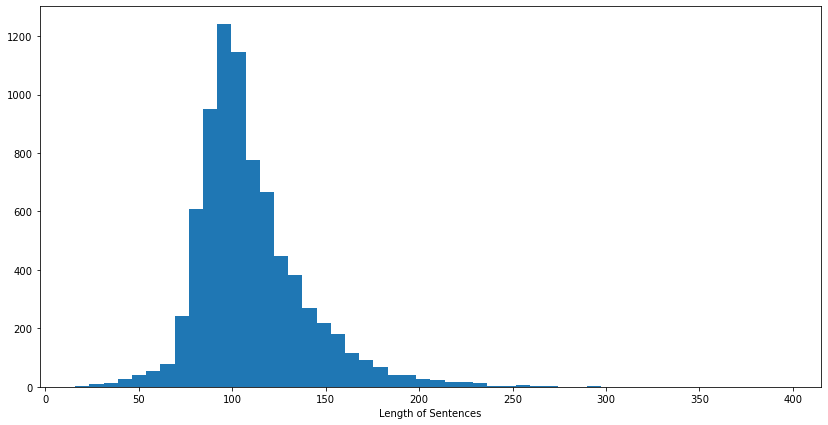

In [126]:
sentence_hist(train2_x)

Sentences are longer in this new data set. In the histogram I can see that the average length of sentences is near 100 words per sentence. I will use 100 as the max sentence length for the model input.

## Preprocessing

In [127]:
MAX_LEN2=100

#fit tokenizer
tokenizer2 = Tokenizer (num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer2.fit_on_texts(train2_x)
word_index = tokenizer2.word_index

#tokenize & pad train data
train2_x_idx = tokenizer2.texts_to_sequences(train2_x)
train2_x_idx = pad_sequences(train2_x_idx, maxlen=MAX_LEN2, padding='post')

#tokenize & pad test data
test2_x_idx = tokenizer.texts_to_sequences(test2_x)
test2_x_idx = pad_sequences(test2_x_idx, maxlen=MAX_LEN2, padding='post')

In [128]:
y2_dict, dictTot2, tags2 = tag_dict(train2_y)
y2_dict

{'Origin': 0,
 'Award': 1,
 'Director': 2,
 'Actor': 3,
 'Character_Name': 4,
 'Opinion': 5,
 'Plot': 6,
 'Soundtrack': 7,
 'Quote': 8,
 'Genre': 9,
 'Relationship': 10,
 'Year': 11,
 'O': 12}

In [129]:
train2_y_idx = tag_transform(y2_dict,train2_y,MAX_LEN2)
test2_y_idx = tag_transform(y2_dict,test2_y,MAX_LEN2)

In [130]:
train2_y_idx[0][:20]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 

## Model Selection and evaluation

In [131]:
input_words2 = Input(shape = (MAX_LEN2,))
model2 = Embedding(input_dim = MAX_WORDS, output_dim = DIM, input_length = MAX_LEN2)(input_words2)
model2 = Dropout(0.2)(model2)
model2 = Bidirectional(LSTM(units = 128,return_sequences = True, recurrent_dropout = 0.1))(model2)
out2 = TimeDistributed(Dense(dictTot2, activation = 'softmax'))(model2)
model2 = Model(inputs=input_words2, outputs=out2)

In [135]:
model2.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 13)           3341      
Total params: 1,237,837
Trainable params: 1,237,837
Non-trainable params: 0
_________________________________________________________________


In [136]:
train2_y_idx=np.array(train2_y_idx)
test2_y_idx=np.array(test2_y_idx)

print(train2_x_idx.shape)
print(train2_y_idx.shape)

(7816, 100)
(7816, 100, 13)


In [137]:
model2.fit(train2_x_idx, train2_y_idx, batch_size = 64, verbose = 1, epochs = 10, validation_split = 0.2)

Epoch 1/10
98/98 [==============================] - 128s 1s/step - loss: 0.4977 - accuracy: 0.8793 - val_loss: 0.3272 - val_accuracy: 0.9115
Epoch 2/10
98/98 [==============================] - 131s 1s/step - loss: 0.2491 - accuracy: 0.9359 - val_loss: 0.2334 - val_accuracy: 0.9290
Epoch 3/10
98/98 [==============================] - 128s 1s/step - loss: 0.1744 - accuracy: 0.9482 - val_loss: 0.1751 - val_accuracy: 0.9484
Epoch 4/10
98/98 [==============================] - 122s 1s/step - loss: 0.1282 - accuracy: 0.9632 - val_loss: 0.1362 - val_accuracy: 0.9592
Epoch 5/10
98/98 [==============================] - 137s 1s/step - loss: 0.0986 - accuracy: 0.9715 - val_loss: 0.1142 - val_accuracy: 0.9650
Epoch 6/10
98/98 [==============================] - 120s 1s/step - loss: 0.0815 - accuracy: 0.9758 - val_loss: 0.1021 - val_accuracy: 0.9693
Epoch 7/10
98/98 [==============================] - 115s 1s/step - loss: 0.0699 - accuracy: 0.9790 - val_loss: 0.0951 - val_accuracy: 0.9712
Epoch 8/10
98

In [138]:
model2.evaluate(test2_x_idx, test2_y_idx)

62/62 [==============================] - 7s 111ms/step - loss: 0.5024 - accuracy: 0.8970


[0.5023682713508606, 0.8970404267311096]

## Potential Improvements
The model reaches 98.45% accuracy in the training data and 89.7% in the test data. This means that the model has a good performance, yet it's slightly overfitting the data, there is almost a 10% decrease in accuracy between the training and testing data. This means there's an opportunity to improve the regularization of the model in order for it to generalize better to unseen data. The potential improvements described in the first section can be applied to this model, in particular it would be useful to try different dropout values or layers, and try applying L2 regularization to the weights of the neural network.